In [2]:
import pandas as pd, numpy as np, os
from get_draws.api import get_draws
from vivarium import Artifact
import scipy.stats as stats
import scipy
from db_queries import get_ids, get_covariate_estimates
from pathlib import Path

# IFA/MMS Gestational Age Shift Calculation
Adapted from https://github.com/ihmeuw/vivarium_research_nutrition_optimization/blob/data_prep/data_prep/antenatal_interventions/Gestational%20age%20shifts.ipynb


In [3]:
# first load baseline coverage data

In [4]:
n_draws = 250
location_ids = [179, 214, 165]  # Ethiopia, Nigeria, Pakistan

In [5]:
art_dir = "/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/"
art_ethiopia = Artifact(Path(art_dir) / "ethiopia.hdf")
art_nigeria = Artifact(Path(art_dir) / "nigeria.hdf")
art_pakistan = Artifact(Path(art_dir) / "pakistan.hdf")

In [6]:
art_ethiopia.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.infant_male_percentage',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'population.scaling_factor',
 'cause.all_causes.cause_specific_mortality_rate',
 'cause.all_causes.all_cause_mortality_risk',
 'population.birth_rate',
 'covariate.age_specific_fertility_rate.estimate',
 'covariate.stillbirth_20_weeks_to_live_birth_ratio.estimate',
 'cause.maternal_abortion_and_miscarriage.raw_incidence_rate',
 'cause.ectopic_pregnancy.raw_incidence_rate',
 'risk_factor.low_birth_weight_and_short_gestation.birth_exposure',
 'risk_factor.low_birth_weight_and_short_gestation.exposure',
 'risk_factor.low_birth_weight_and_short_gestation.distribution',
 'risk_factor.low_birth_weight_and_short_gestation.categories',
 'risk_factor.low_birth_weight_and_short_gestation.sex_specific_ordered_categories',
 'risk_factor.low_birth_weig

In [7]:
# this data comes from Annie Haakkenstad's Health Systems estimates and represents oral iron in pregnancy among those who attend ANC 
ifa = pd.read_csv('anc_iron_prop_st.csv')
ifa = ifa.loc[(ifa.location_id.isin(location_ids)) 
              & (ifa.year_id==2023)]
ifa = ifa.set_index('location_id')[[f'draw_{i}' for i in list(range(0,n_draws))]]
ifa = ifa.stack().reset_index()
ifa.columns = ['location_id', 'draw', 'value']
ifa

,location_id,draw,value
0,165,draw_0,0.713136
1,165,draw_1,0.697265
2,165,draw_2,0.667469
3,165,draw_3,0.740620
4,165,draw_4,0.729679
...,...,...,...
745,214,draw_245,0.827082
746,214,draw_246,0.836488
747,214,draw_247,0.818179
748,214,draw_248,0.830268


In [ ]:
def load_ifa(artifact):
    return artifact.load('risk_factor.iron_folic_acid_supplementation.coverage').drop([""])


In [24]:
# TODO: use artifact data (key IFA_SUPPLEMENTATION.COVERAGE)

ifa_ethiopia = art_ethiopia.load('risk_factor.iron_folic_acid_supplementation.coverage') #.stack().reset_index()
#ifa_ethiopia["location_id"] = 179
ifa_nigeria = art_nigeria.load('risk_factor.iron_folic_acid_supplementation.coverage') #.stack().reset_index()
#ifa_nigeria["location_id"] = 214
ifa_pakistan = art_pakistan.load('risk_factor.iron_folic_acid_supplementation.coverage') #.stack().reset_index()
#ifa_pakistan["location_id"] = 165

pd.concat([ifa_ethiopia, ifa_nigeria, ifa_pakistan])
art_ethiopia.load('risk_factor.iron_folic_acid_supplementation.coverage').reset_index(level="location_id")

KeyError: 'Level location_id not found'

In [ ]:
# load ANC1 so that we can adjust accoringly
anc = get_covariate_estimates(location_id=[179, 214, 165], 
                        year_id=2023,
                        release_id=16, 
                        covariate_id=7)
anc = anc.set_index('location_id')[[c for c in anc.columns if 'value' in c and c != 'location_id']].reset_index()
anc

,location_id,mean_value,lower_value,upper_value
0,165,0.924081,0.870858,0.958652
1,179,0.775637,0.657029,0.867886
2,214,0.740780,0.686991,0.791562


In [ ]:
# TODO: use artifact data (key 'covariate.antenatal_care_1_visit_coverage_proportion.estimate')

In [24]:
anc_draws = pd.DataFrame()
for i in anc.index:
    temp = anc.loc[i]
    draws = scipy.stats.norm(temp.mean_value, (temp.upper_value - temp.lower_value)/2/1.96).rvs(size=n_draws, random_state=123)
    anc_draws[temp.location_id] = draws
anc_draws = pd.DataFrame(anc_draws.stack()).reset_index().rename(columns={'level_0':'draw','level_1':'location_id',0:'value'})
anc_draws['draw'] = 'draw_' + anc_draws.draw.astype(str)
anc_draws['location_id'] = anc_draws.location_id.astype(int)
anc_draws

,draw,location_id,value
0,draw_0,165,0.899767
1,draw_0,179,0.717241
2,draw_0,214,0.711819
3,draw_1,165,0.946418
4,draw_1,179,0.829285
...,...,...,...
745,draw_248,179,0.696829
746,draw_248,214,0.701696
747,draw_249,165,0.932221
748,draw_249,179,0.795187


In [29]:
anc_draws.groupby(['location_id'])['value'].describe(percentiles=[0.025,0.975])

,count,mean,std,min,2.5%,50%,97.5%,max
location_id,,,,,,,,
165,250.0,0.923619,0.022833,0.851717,0.878965,0.923878,0.970181,0.982273
179,250.0,0.774529,0.054839,0.601838,0.667281,0.775150,0.886358,0.915401
214,250.0,0.740230,0.027197,0.654587,0.687042,0.740538,0.795690,0.810093


In [31]:
baseline_ifa = (ifa.set_index(['location_id','draw']) * anc_draws.set_index(['location_id','draw'])).reset_index()
baseline_ifa

,location_id,draw,value
0,165,draw_0,0.641656
1,165,draw_1,0.659904
2,165,draw_10,0.700575
3,165,draw_100,0.634310
4,165,draw_101,0.656952
...,...,...,...
745,214,draw_95,0.634845
746,214,draw_96,0.576563
747,214,draw_97,0.574863
748,214,draw_98,0.632751


In [32]:
baseline_ifa.groupby('location_id')['value'].describe(percentiles=[0.025,0.975]).filter(['mean','2.5%','97.5%'])

,mean,2.5%,97.5%
location_id,,,
165,0.664249,0.616378,0.716986
179,0.433126,0.365852,0.505559
214,0.616748,0.571875,0.670521


In [8]:
# IRA OR: 0.9 (0.86, 0.95) relative to no IFA
# MMS RR: 0.91 (0.84, 0.99) relative to IFA... UPDATED FROM: 0.95 (0.90, 1.01) relative to IFA
# MMS VERY PRETERM: RR = 0.81 (0.71, 0.93) relative to IFA

In [9]:
# generate lognormal distribution of IFA OR

In [33]:
def lognorm_from_median_lower_upper(median, lower, upper, quantile_ranks=(0.025,0.975)):
  """Returns a frozen lognormal distribution with the specified median, such that
  the values (lower, upper) are approximately equal to the quantiles with ranks
  (quantile_ranks[0], quantile_ranks[1]). More precisely, if q0 and q1 are
  the quantiles of the returned distribution with ranks quantile_ranks[0]
  and quantile_ranks[1], respectively, then q1/q0 = upper/lower. If the
  quantile ranks are symmetric about 0.5, lower and upper will coincide with
  q0 and q1 precisely when median^2 = lower*upper.
  """
  # Let Y ~ Norm(mu, sigma^2) and X = exp(Y), where mu = log(median)
  # so X ~ Lognorm(s=sigma, scale=exp(mu)) in scipy's notation.
  # We will determine sigma from the two specified quantiles lower and upper.

  # mean (and median) of the normal random variable Y = log(X)
  mu = np.log(median)
  # quantiles of the standard normal distribution corresponding to quantile_ranks
  stdnorm_quantiles = stats.norm.ppf(quantile_ranks)
  # quantiles of Y = log(X) corresponding to the quantiles (lower, upper) for X
  norm_quantiles = np.log([lower, upper])
  # standard deviation of Y = log(X) computed from the above quantiles for Y
  # and the corresponding standard normal quantiles
  sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
  # Frozen lognormal distribution for X = exp(Y)
  # (s=sigma is the shape parameter; the scale parameter is exp(mu), which equals the median)
  return stats.lognorm(s=sigma, scale=median)

In [34]:
dist = lognorm_from_median_lower_upper(0.9, 0.86, 0.96, quantile_ranks=(0.025,0.975))
dist.ppf(0.975)

0.9508869788316736

In [35]:
dist.ppf(0.025)

0.8518362518700411

In [36]:
dist.ppf(0.5)

0.9

In [37]:
dist.mean()

0.9003544331065376

In [ ]:
# This doesn't exist in the artifact and so can be kept in the nb
ifa_rr_draws = pd.DataFrame()
ifa_rr_draws['draw'] = [f'draw_{x}' for x in list(range(0,n_draws))]
ifa_rr_draws['rr'] = dist.rvs(size=n_draws, random_state=456)
ifa_rr_draws

,draw,rr
0,draw_0,0.883283
1,draw_1,0.887505
2,draw_2,0.915759
3,draw_3,0.914478
4,draw_4,0.934763
...,...,...
245,draw_245,0.868767
246,draw_246,0.897371
247,draw_247,0.853599
248,draw_248,0.856725


In [40]:
ifa_rr_draws.rr.describe(percentiles=[0.025,0.975])

count    250.000000
mean       0.901225
std        0.026457
min        0.828957
2.5%       0.853091
50%        0.900379
97.5%      0.953219
max        0.967375
Name: rr, dtype: float64

# First, let's just load in LBWSG exposure data

In [41]:
# Load Nathaniel's CSV that map LBWSG categories to BW and GA continuous values
art_exposure = pd.read_csv('lbwsg_category_data_gbd_2021.csv').rename(columns={'lbwsg_category':'parameter'})
art_exposure = art_exposure[['parameter','ga_start','ga_end','bw_start','bw_end']] # Only keep the columns that we need right now 
art_exposure

,parameter,ga_start,ga_end,bw_start,bw_end
0,cat2,0,24,0,500
1,cat8,0,24,500,1000
2,cat10,24,26,500,1000
3,cat11,26,28,500,1000
4,cat14,30,32,500,1000
5,cat15,28,30,500,1000
6,cat17,26,28,1000,1500
7,cat19,34,36,1000,1500
8,cat20,28,30,1500,2000
9,cat21,28,30,1000,1500


In [42]:
%%time
exposure = get_draws(release_id=9,
               year_id=2021, 
               location_id=location_ids, 
               age_group_id=164, # birth
               gbd_id_type='rei_id',
               gbd_id=339,
               source='exposure')
exp = exposure.merge(art_exposure, on='parameter')
exp = exp.drop(columns=['rei_id','modelable_entity_id','year_id','measure_id','metric_id','model_version_id'])
exp['ga_start'] = exp.ga_start.astype(float)
exp['ga_end'] = exp.ga_end.astype(float)
exp

CPU times: user 2min 4s, sys: 12.3 s, total: 2min 17s
Wall time: 5min 23s


,location_id,age_group_id,sex_id,parameter,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,...,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,ga_start,ga_end,bw_start,bw_end
0,214,164,1,cat2,0.000764,0.000672,0.000597,0.000693,0.000639,0.000693,...,0.000639,0.000598,0.000698,0.000615,0.000644,0.000764,0.0,24.0,0,500
1,214,164,2,cat2,0.000585,0.000604,0.000623,0.000599,0.000606,0.000720,...,0.000560,0.000607,0.000620,0.000591,0.000636,0.000585,0.0,24.0,0,500
2,179,164,2,cat2,0.000458,0.000529,0.000601,0.000587,0.000732,0.000557,...,0.000559,0.000699,0.000479,0.000419,0.000779,0.000458,0.0,24.0,0,500
3,179,164,1,cat2,0.000614,0.000646,0.000557,0.000669,0.000643,0.000719,...,0.000579,0.000583,0.000836,0.000789,0.000601,0.000614,0.0,24.0,0,500
4,165,164,2,cat2,0.000930,0.001126,0.000633,0.000743,0.001107,0.000812,...,0.000864,0.000912,0.001164,0.001820,0.001025,0.000930,0.0,24.0,0,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,214,164,2,cat123,0.002853,0.002730,0.002958,0.002907,0.002922,0.002877,...,0.002893,0.002876,0.002969,0.002885,0.002821,0.002853,40.0,42.0,1500,2000
344,179,164,2,cat123,0.003221,0.002773,0.003621,0.003073,0.002963,0.003355,...,0.003620,0.003170,0.002814,0.003194,0.003726,0.003221,40.0,42.0,1500,2000
345,179,164,1,cat123,0.002473,0.002720,0.002787,0.002449,0.002858,0.003094,...,0.002677,0.002537,0.002974,0.002615,0.002849,0.002473,40.0,42.0,1500,2000
346,165,164,2,cat123,0.005273,0.005725,0.005597,0.006084,0.006699,0.006150,...,0.004707,0.005095,0.005743,0.005096,0.005215,0.005273,40.0,42.0,1500,2000


In [45]:
data = exp.set_index([c for c in exp.columns if 'draw' not in c]).stack().reset_index()
data = data.rename(columns={'level_8':'draw',0:'exposure'})
data = data.merge(ifa_rr_draws, on='draw')
    # TAKE MEAN ACROSS SEXES
data = data.groupby(['location_id','age_group_id','parameter','bw_start','bw_end',
                    'ga_start','ga_end','draw','rr']).exposure.mean().reset_index()
data = data.merge(baseline_ifa.rename(columns={'value':'ifa_coverage'}), on=['location_id','draw'])
data

,location_id,age_group_id,parameter,bw_start,bw_end,ga_start,ga_end,draw,rr,exposure,ifa_coverage
0,165,164,cat10,500,1000,24.0,26.0,draw_0,0.883283,0.000901,0.641656
1,165,164,cat106,1000,1500,36.0,37.0,draw_0,0.883283,0.000995,0.641656
2,165,164,cat11,500,1000,26.0,28.0,draw_0,0.883283,0.001250,0.641656
3,165,164,cat116,1000,1500,38.0,40.0,draw_0,0.883283,0.007623,0.641656
4,165,164,cat117,1500,2000,38.0,40.0,draw_0,0.883283,0.017419,0.641656
...,...,...,...,...,...,...,...,...,...,...,...
43495,214,164,cat88,2500,3000,30.0,32.0,draw_99,0.910079,0.005964,0.609858
43496,214,164,cat89,3000,3500,30.0,32.0,draw_99,0.910079,0.001719,0.609858
43497,214,164,cat90,3500,4000,30.0,32.0,draw_99,0.910079,0.000305,0.609858
43498,214,164,cat95,3000,3500,32.0,34.0,draw_99,0.910079,0.005447,0.609858


In [20]:
# ok, so to generate uncovered distribution...
    # uncovered mean GA = population mean GA - coverage * GA_shift
    # in other words, shift everything down by shift multiplied by coverage

In [ ]:
draw = 0
location_id = 179
test = data.loc[(data.draw==f'draw_{draw}')&(data.location_id==location_id)]
coverage = test['ifa_coverage'].values[0]
test = test.set_index([c for c in data.columns if 'ga_' not in c]) 
test

ga_start  \
location_id age_group_id parameter bw_start bw_end draw   rr       exposure ifa_coverage             
179         164          cat10     500      1000   draw_0 0.883283 0.000759 0.387017          24.0   
                         cat106    1000     1500   draw_0 0.883283 0.000631 0.387017          36.0   
                         cat11     500      1000   draw_0 0.883283 0.000548 0.387017          26.0   
                         cat116    1000     1500   draw_0 0.883283 0.004821 0.387017          38.0   
                         cat117    1500     2000   draw_0 0.883283 0.009788 0.387017          38.0   
                         cat123    1500     2000   draw_0 0.883283 0.002847 0.387017          40.0   
                         cat124    1000     1500   draw_0 0.883283 0.003614 0.387017          37.0   
                         cat14     500      1000   draw_0 0.883283 0.000287 0.387017          30.0   
                         cat15     500      1000   draw_0 0.883283 0.000657 0.387017          28.0   
                         cat17     1000     1500   draw_0 0.883283 0.001199 0.387017          26.0   
                         cat19     1000     1500   draw_0 0.883283 0.001133 0.387017          34.0   
                         cat2      0        500    draw_0 0.883283 0.000536 0.387017           0.0   
                         cat20     1500     2000   draw_0 0.883283 0.002347 0.387017          28.0   
                         cat21     1000     1500   draw_0 0.883283 0.001929 0.387017          28.0   
                         cat22     1000     1500   draw_0 0.883283 0.001518 0.387017          32.0   
                         cat23     1000     1500   draw_0 0.883283 0.001656 0.387017          30.0   
                         cat24     1500     2000   draw_0 0.883283 0.007138 0.387017          37.0   
                         cat25     1500     2000   draw_0 0.883283 0.001425 0.387017          36.0   
                         cat26     2000     2500   draw_0 0.883283 0.003891 0.387017          30.0   
                         cat27     1500     2000   draw_0 0.883283 0.004088 0.387017          30.0   
                         cat28     1500     2000   draw_0 0.883283 0.003324 0.387017          34.0   
                         cat29     1500     2000   draw_0 0.883283 0.004409 0.387017          32.0   
                         cat30     2000     2500   draw_0 0.883283 0.006859 0.387017          32.0   
                         cat31     2000     2500   draw_0 0.883283 0.005266 0.387017          40.0   
                         cat32     2000     2500   draw_0 0.883283 0.017570 0.387017          38.0   
                         cat33     2500     3000   draw_0 0.883283 0.014758 0.387017          32.0   
                         cat34     2000     2500   draw_0 0.883283 0.007535 0.387017          34.0   
                         cat35     2000     2500   draw_0 0.883283 0.013933 0.387017          37.0   
                         cat36     2000     2500   draw_0 0.883283 0.003508 0.387017          36.0   
                         cat37     2500     3000   draw_0 0.883283 0.030401 0.387017          34.0   
                         cat38     4000     9999   draw_0 0.883283 0.000436 0.387017          34.0   
                         cat39     3000     3500   draw_0 0.883283 0.014305 0.387017          34.0   
                         cat40     2500     3000   draw_0 0.883283 0.019698 0.387017          36.0   
                         cat41     3500     4000   draw_0 0.883283 0.002819 0.387017          34.0   
                         cat42     2500     3000   draw_0 0.883283 0.088082 0.387017          37.0   
                         cat43     2500     3000   draw_0 0.883283 0.028253 0.387017          40.0   
                         cat44     2500     3000   draw_0 0.883283 0.102385 0.387017          38.0   
                         cat45     3000     3500   draw_0 0.883283 0.012301 0.387017          36.0   
          

In [49]:
def calculate_shift_from_rr(draw, location_id):
    exp = data.loc[(data.draw==f'draw_{draw}')&(data.location_id==location_id)]
    coverage = exp['ifa_coverage'].values[0]
    exp = exp.set_index([c for c in data.columns if 'ga_' not in c]) # gestational age columns are the operative ones (shift gets added to these)
    def shift_optimization(shift):
        exp_uncovered = (exp - (shift * coverage)).reset_index()
        exp_uncovered['frac_ptb'] = np.where(exp_uncovered.ga_start >= 37, 0,
                                        np.where(exp_uncovered.ga_end < 37, 1,
                                                (37 - exp_uncovered.ga_start)/(exp_uncovered.ga_end - exp_uncovered.ga_start)
                                                ))
        uncovered_ptb = (exp_uncovered.exposure * exp_uncovered.frac_ptb).sum()
        exp_covered = exp_uncovered.set_index([c for c in exp_uncovered.columns if 'ga_' not in c]) + shift
        exp_covered = exp_covered.reset_index()
        exp_covered['frac_ptb'] = np.where(exp_covered.ga_start >= 37, 0,
                                            np.where(exp_covered.ga_end < 37, 1,
                                                    (37 - exp_covered.ga_start)/(exp_covered.ga_end - exp_covered.ga_start)
                                                    ))
        covered_ptb = (exp_covered.exposure * exp_covered.frac_ptb).sum()
        rr = covered_ptb / uncovered_ptb
        return np.abs(rr - exp_covered.rr[0])
    return scipy.optimize.minimize_scalar(shift_optimization, bounds=(-1, 2), method='bounded')['x']

In [50]:
# Test with one draw and one country first
test_draw = 1
calculate_shift_from_rr(test_draw, 179) 

# Great, looks like it works? Now let's calculate with all draws and all countries

0.14774209901810967

In [51]:
%%time 

ethiopia_ifa_shifts = []
nigeria_ifa_shifts = []
pakistan_ifa_shifts = []
for draw in list(range(0,n_draws)):
    ethiopia_ifa_shifts.append(calculate_shift_from_rr(draw, 179))
    nigeria_ifa_shifts.append(calculate_shift_from_rr(draw, 214))
    pakistan_ifa_shifts.append(calculate_shift_from_rr(draw, 165))

CPU times: user 1min 55s, sys: 140 ms, total: 1min 56s
Wall time: 1min 56s


In [52]:
# ethiopia
print(np.array(ethiopia_ifa_shifts).mean().round(2), 
      np.quantile(np.array(ethiopia_ifa_shifts), 0.025).round(2),
      np.quantile(np.array(ethiopia_ifa_shifts), 0.975).round(2))

0.13 0.06 0.21


In [53]:
# nigeria
print(np.array(nigeria_ifa_shifts).mean().round(2), 
      np.quantile(np.array(nigeria_ifa_shifts), 0.025).round(2),
      np.quantile(np.array(nigeria_ifa_shifts), 0.975).round(2))

0.1 0.05 0.16


In [54]:
# pakistan
print(np.array(pakistan_ifa_shifts).mean().round(2), 
      np.quantile(np.array(pakistan_ifa_shifts), 0.025).round(2),
      np.quantile(np.array(pakistan_ifa_shifts), 0.975).round(2))

0.1 0.04 0.16


In [27]:
# ok, IFA shifts for Ethiopia: +0.13 (95% UI: 0.06, 0.21) weeks
# IFA shifts for Nigeria and Pakistan: +0.11 (95% UI: 0.05, 0.16) weeks

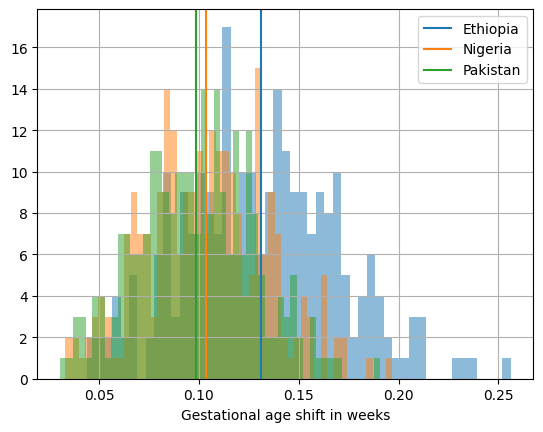

In [55]:
import matplotlib.pyplot as plt
plt.hist(ethiopia_ifa_shifts, bins=50, alpha=0.5)
plt.hist(nigeria_ifa_shifts, bins=50, alpha=0.5)
plt.hist(pakistan_ifa_shifts, bins=50, alpha=0.5)
plt.axvline(np.array(ethiopia_ifa_shifts).mean(), color='tab:blue')
plt.axvline(np.array(nigeria_ifa_shifts).mean(), color='tab:orange')
plt.axvline(np.array(pakistan_ifa_shifts).mean(), color='tab:green')
plt.grid()
plt.legend(['Ethiopia','Nigeria','Pakistan'])
plt.xlabel('Gestational age shift in weeks')
plt.show()

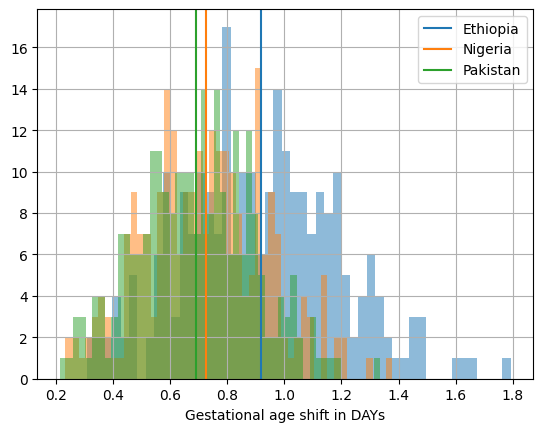

In [56]:
import matplotlib.pyplot as plt
plt.hist([x*7 for x in ethiopia_ifa_shifts], bins=50, alpha=0.5)
plt.hist([x*7 for x in nigeria_ifa_shifts], bins=50, alpha=0.5)
plt.hist([x*7 for x in pakistan_ifa_shifts], bins=50, alpha=0.5)
plt.axvline(np.array(ethiopia_ifa_shifts).mean() * 7, color='tab:blue')
plt.axvline(np.array(nigeria_ifa_shifts).mean() * 7, color='tab:orange')
plt.axvline(np.array(pakistan_ifa_shifts).mean() * 7, color='tab:green')
plt.grid()
#plt.xlim(0,0.4)
plt.legend(['Ethiopia','Nigeria','Pakistan'])
plt.xlabel('Gestational age shift in DAYs')
plt.show()

In [57]:
ifa_shifts = pd.DataFrame()
ifa_shifts[179] = ethiopia_ifa_shifts
ifa_shifts[214] = nigeria_ifa_shifts
ifa_shifts[165] = pakistan_ifa_shifts
ifa_shifts = ifa_shifts.stack().reset_index().rename(columns={'level_0':'draw','level_1':'location_id',0:'value'})
ifa_shifts['draw'] = 'draw_' + ifa_shifts.draw.astype(str)
ifa_shifts

,draw,location_id,value
0,draw_0,179,0.168249
1,draw_0,214,0.130013
2,draw_0,165,0.119326
3,draw_1,179,0.147742
4,draw_1,214,0.116632
...,...,...,...
745,draw_248,214,0.162844
746,draw_248,165,0.146913
747,draw_249,179,0.157675
748,draw_249,214,0.129508


In [58]:
ifa_shifts.to_csv('ifa_ga_shifts.csv')

In [59]:
ifa_shifts = pd.read_csv('ifa_ga_shifts.csv').drop(columns='Unnamed: 0')
ifa_shifts

,draw,location_id,value
0,draw_0,179,0.168249
1,draw_0,214,0.130013
2,draw_0,165,0.119326
3,draw_1,179,0.147742
4,draw_1,214,0.116632
...,...,...,...
745,draw_248,214,0.162844
746,draw_248,165,0.146913
747,draw_249,179,0.157675
748,draw_249,214,0.129508


In [60]:
exp_prepped = exp.set_index([c for c in exp.columns if 'draw' not in c]).stack().reset_index()
exp_prepped = exp_prepped.rename(columns={'level_8':'draw',0:'exposure'})
uncovered_shift = (-ifa_shifts.set_index(['location_id','draw']) * baseline_ifa.set_index(['location_id','draw']))
uncovered_shift = uncovered_shift.reset_index().rename(columns={'value':'uncovered_shift'})
uncovered_exp = exp_prepped.merge(uncovered_shift, on=['location_id','draw'])
uncovered_exp['ga_start'] = uncovered_exp.ga_start + uncovered_exp.uncovered_shift
uncovered_exp['ga_end'] = uncovered_exp.ga_end + uncovered_exp.uncovered_shift
uncovered_exp['frac_ptb'] = np.where(uncovered_exp.ga_start >= 37, 0,
                                    np.where(uncovered_exp.ga_end < 37, 1, 
                                            (37 - uncovered_exp.ga_start) / (uncovered_exp.ga_end - uncovered_exp.ga_start)))
uncovered_exp['exposure_ptb'] = uncovered_exp.frac_ptb * uncovered_exp.exposure
uncovered_ptb = uncovered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb']]
uncovered_ptb.groupby('location_id').describe(percentiles=[0.025,0.975])[['exposure_ptb']]

/tmp/ipykernel_2106044/33346034.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  uncovered_ptb = uncovered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb']]


exposure_ptb                                                    \
                   count      mean       std       min      2.5%       50%   
location_id                                                                  
165                250.0  0.359957  0.010860  0.330464  0.339650  0.359530   
179                250.0  0.355475  0.009999  0.329672  0.337776  0.355308   
214                250.0  0.358755  0.009600  0.336027  0.340732  0.358489   

                                 
                97.5%       max  
location_id                      
165          0.381970  0.390399  
179          0.375770  0.383375  
214          0.377735  0.384434

In [61]:
covered_shift = (-ifa_shifts.set_index(['location_id','draw']) * baseline_ifa.set_index(['location_id','draw'])
                + ifa_shifts.set_index(['location_id','draw']))
covered_shift = covered_shift.reset_index().rename(columns={'value':'covered_shift'})
covered_exp = exp_prepped.merge(covered_shift, on=['location_id','draw'])
covered_exp['ga_start'] = covered_exp.ga_start + covered_exp.covered_shift
covered_exp['ga_end'] = covered_exp.ga_end + covered_exp.covered_shift
covered_exp['frac_ptb'] = np.where(covered_exp.ga_start > 37, 0,
                                    np.where(covered_exp.ga_end < 37, 1, 
                                            (37 - covered_exp.ga_start) / (covered_exp.ga_end - covered_exp.ga_start)))
covered_exp['exposure_ptb'] = covered_exp.frac_ptb * covered_exp.exposure

# Add exposure_vptb calculation for MMS validation
covered_exp['frac_vptb'] = np.where(covered_exp.ga_start >= 32, 0,
                                    np.where(covered_exp.ga_end < 32, 1, 
                                            (32 - covered_exp.ga_start) / (covered_exp.ga_end - covered_exp.ga_start)))
covered_exp['exposure_vptb'] = covered_exp.frac_vptb * covered_exp.exposure

covered_ptb = covered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb', 'exposure_vptb']]
covered_ptb.groupby('location_id').describe(percentiles=[0.025,0.975])[['exposure_ptb']]

/tmp/ipykernel_2106044/3696864408.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  covered_ptb = covered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb', 'exposure_vptb']]


exposure_ptb                                                    \
                   count      mean       std       min      2.5%       50%   
location_id                                                                  
165                250.0  0.324150  0.004749  0.309158  0.314461  0.324168   
179                250.0  0.320129  0.004348  0.308395  0.311659  0.320182   
214                250.0  0.323071  0.001853  0.318680  0.319609  0.322961   

                                 
                97.5%       max  
location_id                      
165          0.332998  0.338745  
179          0.328250  0.329886  
214          0.326953  0.328622

In [62]:
print('Validation target is: ',ifa_rr_draws.rr.mean().round(3),
      ' (95% CI: ',ifa_rr_draws.rr.quantile(0.025).round(3), 
      ", ",ifa_rr_draws.rr.quantile(0.975).round(3), ")")
ifa_rrs_observed = covered_ptb / uncovered_ptb
ifa_rrs_observed.groupby('location_id')['exposure_ptb'].describe(percentiles=[0.025,0.975]).filter(['mean','2.5%','97.5%'])

Validation target is:  0.901  (95% CI:  0.853 ,  0.953 )


,mean,2.5%,97.5%
location_id,,,
165,0.901225,0.853091,0.953217
179,0.901225,0.853091,0.953218
214,0.901225,0.853093,0.953220


# Ok now for MMS

RR for preterm birth (37 weeks) relative to IFA: 0.91 (0.84, 0.99)... updated from: 0.95 (0.90, 1.01)

RR for very preterm birth (32 weeks) relative to IFA: 0.81 (0.71, 0.93)

In [63]:
mms_pt_dist = lognorm_from_median_lower_upper(0.91, 0.84, 0.99, quantile_ranks=(0.025,0.975))
mms_pt_rr_draws = pd.DataFrame()
mms_pt_rr_draws['draw'] = [f'draw_{x}' for x in list(range(0,1000))]
mms_pt_rr_draws['rr'] = mms_pt_dist.rvs(size=1000, random_state=789)
mms_pt_rr_draws.describe(percentiles=[0.025,0.975])

,rr
count,1000.000000
mean,0.911593
std,0.038959
min,0.805398
2.5%,0.840395
50%,0.910992
97.5%,0.987215
max,1.060023


In [64]:
mms_vpt_dist = lognorm_from_median_lower_upper(0.81, 0.71, 0.93, quantile_ranks=(0.025,0.975))
mms_vpt_rr_draws = pd.DataFrame()
mms_vpt_rr_draws['draw'] = [f'draw_{x}' for x in list(range(0,1000))]
mms_vpt_rr_draws['rr'] = mms_vpt_dist.rvs(size=1000, random_state=101112)
mms_vpt_rr_draws.describe(percentiles=[0.025,0.975])

,rr
count,1000.000000
mean,0.813379
std,0.056937
min,0.652445
2.5%,0.706016
50%,0.812928
97.5%,0.936343
max,1.015526


In [65]:
ifa_exp = covered_exp.copy().drop(columns='covered_shift')
ifa_exp = ifa_exp.groupby([c for c in ifa_exp if c!='sex_id' and 'exposure' not in c]).mean().reset_index()
ifa_exp['frac_vptb'] = np.where(ifa_exp.ga_start >= 32, 0,
                                        np.where(ifa_exp.ga_end < 32, 1,
                                                (32 - ifa_exp.ga_start)/(ifa_exp.ga_end - ifa_exp.ga_start)
                                                ))
ifa_exp['exposure_vptb'] = ifa_exp.frac_vptb * ifa_exp.exposure
data_mms_pt = ifa_exp.merge(mms_pt_rr_draws, on='draw').drop(columns=['frac_vptb'])
data_mms_vpt = ifa_exp.merge(mms_vpt_rr_draws, on='draw')#.drop(columns=['frac_ptb'])
data_mms_pt.head()

,location_id,age_group_id,parameter,ga_start,ga_end,bw_start,bw_end,draw,frac_ptb,sex_id,exposure,exposure_ptb,exposure_vptb,rr
0,165,164,cat10,24.010814,26.010814,500,1000,draw_117,1.000000,1.5,0.000637,0.000637,0.000637,0.91875
1,165,164,cat106,36.010814,37.010814,1000,1500,draw_117,0.989186,1.5,0.000984,0.000974,0.000000,0.91875
2,165,164,cat11,26.010814,28.010814,500,1000,draw_117,1.000000,1.5,0.000846,0.000846,0.000846,0.91875
3,165,164,cat116,38.010814,40.010814,1000,1500,draw_117,0.000000,1.5,0.007943,0.000000,0.000000,0.91875
4,165,164,cat117,38.010814,40.010814,1500,2000,draw_117,0.000000,1.5,0.017253,0.000000,0.000000,0.91875


In [66]:
def mms_shift(draw, location_id, ptb = True):
    if ptb:
        threshold = 'ptb'
        threshold_val = 37
        data = data_mms_pt.copy()
    else:
        threshold = 'vptb'
        threshold_val = 32
        data = data_mms_vpt.copy()
    exp_uncovered = data.loc[(data.draw==f'draw_{draw}')&(data.location_id==location_id)]
    uncovered_low = exp_uncovered[f'exposure_{threshold}'].sum()
    def shift_optimization(shift):
        exp_covered = exp_uncovered.set_index([c for c in exp_uncovered.columns if 'ga_' not in c]) + shift
        exp_covered = exp_covered.reset_index()
        exp_covered[f'frac_{threshold}'] = np.where(exp_covered.ga_start >= threshold_val, 0,
                                            np.where(exp_covered.ga_end < threshold_val, 1,
                                                    (threshold_val - exp_covered.ga_start)/(exp_covered.ga_end - exp_covered.ga_start)
                                                    ))
        covered_low = (exp_covered.exposure * exp_covered[f'frac_{threshold}']).sum()
        rr = covered_low / uncovered_low
        return np.abs(rr - exp_covered.rr[0])
    return scipy.optimize.minimize_scalar(shift_optimization, bounds=(-2, 2), method='bounded')['x']

In [67]:
draw = 0
location_id = 179

mms_shift(draw, location_id, ptb = True)

0.5100398437410506

In [68]:
mms_shift(draw, location_id, ptb = False)

0.6613351606388954

In [69]:
location_id=179

vptb_shifts = []
ptb_shifts = []
for draw in list(range(0,100)):
    vptb_shifts.append(mms_shift(draw, location_id, ptb = False))
    ptb_shifts.append(mms_shift(draw, location_id, ptb = True))

In [70]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'MMS gestational age shifts for Ethiopia, 100 draws')

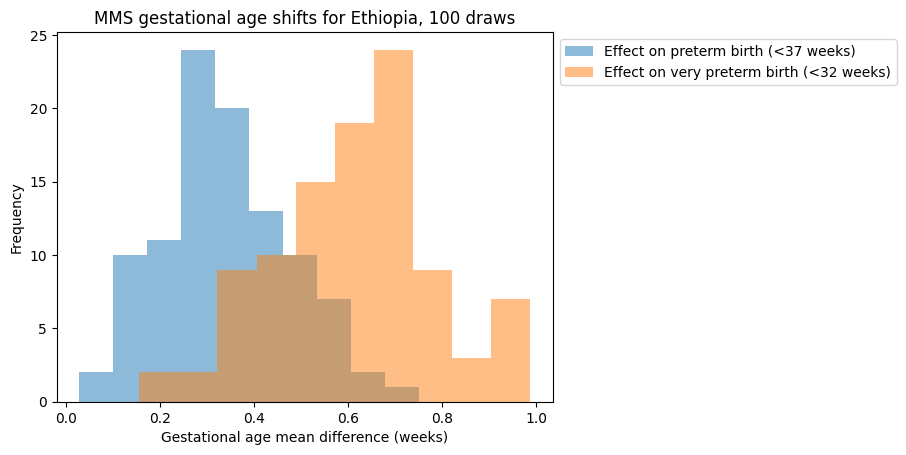

In [71]:
plt.hist(ptb_shifts, alpha=0.5)
plt.hist(vptb_shifts, alpha=0.5)
plt.legend(['Effect on preterm birth (<37 weeks)',
           'Effect on very preterm birth (<32 weeks)'], bbox_to_anchor=[1,1])
plt.xlabel('Gestational age mean difference (weeks)')
plt.ylabel('Frequency')
plt.title("MMS gestational age shifts for Ethiopia, 100 draws")

    # conclusion: we will overestimate the effect of MMS on preterm birth (<37 weeks)
    # if we move forward with the GA shifts that accurately replicates the effect
    # on very preterm birth (<32 weeks)
    
    # and likewise, we will underestimate the effect of MMS on VPTB if we use the shifts
    # from the PTB impacts
    
        # SHOULD WE JUST TAKE THE OVERLAPPING REGION? I think no

In [72]:
# ok let's try some sort of joint approach?
    # first, apply the VPTB shift relative to IFA
    # then, for those who are not VPTB, find a new shift to correct for initial overestimate

In [73]:
def mms_double_shift(draw, location_id):
    
    ptb_rr = mms_pt_rr_draws.loc[mms_pt_rr_draws.draw==f'draw_{draw}'].rr.values[0]
    vptb_rr = mms_vpt_rr_draws.loc[mms_vpt_rr_draws.draw==f'draw_{draw}'].rr.values[0]
    
    exp_uncovered = data_mms_vpt.loc[(data_mms_vpt.draw==f'draw_{draw}')&(data_mms_vpt.location_id==location_id)]
    uncovered_vptb = exp_uncovered.exposure_vptb.sum()
    uncovered_ptb = exp_uncovered.exposure_ptb.sum()
    def vptb_shift_optimization(shift):
        exp_covered = exp_uncovered.set_index([c for c in exp_uncovered.columns if 'ga_' not in c]) + shift
        exp_covered = exp_covered.reset_index()
        exp_covered['frac_vptb'] = np.where(exp_covered.ga_start >= 32, 0,
                                            np.where(exp_covered.ga_end < 32, 1,
                                                    (32 - exp_covered.ga_start)/(exp_covered.ga_end - exp_covered.ga_start)))
        covered_vptb = (exp_covered.exposure * exp_covered['frac_vptb']).sum()
        rr = covered_vptb / uncovered_vptb
        return np.abs(rr - vptb_rr)
    vptb_shift = scipy.optimize.minimize_scalar(vptb_shift_optimization, bounds=(-2, 2), method='bounded')['x']
    mms1 = exp_uncovered.set_index([c for c in exp_uncovered.columns if 'ga_' not in c]) + vptb_shift
    mms1 = mms1.reset_index()
    mms1['frac_vptb'] = np.where(mms1.ga_start >= 32, 0,
                                            np.where(mms1.ga_end < 32, 1,
                                                    (32 - mms1.ga_start)/(mms1.ga_end - mms1.ga_start)))
    mms1['frac_ptb'] = np.where(mms1.ga_start >= 37, 0,
                                            np.where(mms1.ga_end < 37, 1,
                                                    (37 - mms1.ga_start)/(mms1.ga_end - mms1.ga_start)))
    mms1_vptb = (mms1.exposure * mms1.frac_vptb).sum()
    mms1_ptb = (mms1.exposure * mms1.frac_ptb).sum()
    
    def second_shift_optimization(shift):
        mms2 = mms1.copy()
        mms2['ga_start'] = np.where(mms2.ga_start < (32 - shift), mms2.ga_start, mms2.ga_start + shift)
        mms2['ga_end'] = np.where(mms2.ga_start < (32 - shift), mms2.ga_end, mms2.ga_end + shift)
        mms2 = mms2.reset_index()
        mms2['frac_ptb'] = np.where(mms2.ga_start >= 37, 0,
                                            np.where(mms2.ga_end < 37, 1,
                                                    (37 - mms2.ga_start)/(mms2.ga_end - mms2.ga_start)))
        mms2['frac_vptb'] = np.where(mms2.ga_start >= 32, 0,
                                            np.where(mms2.ga_end < 32, 1,
                                                    (32 - mms2.ga_start)/(mms2.ga_end - mms2.ga_start)))
        mms2_ptb = (mms2.exposure * mms2['frac_ptb']).sum()
        mms2_vptb = (mms2.exposure * mms2.frac_vptb).sum()
        rr = mms2_ptb / uncovered_ptb
        return np.abs(rr - ptb_rr)
    second_shift = scipy.optimize.minimize_scalar(second_shift_optimization, bounds=(-5, 5), method='bounded')['x']
    
    return vptb_shift, second_shift

In [74]:
mms_double_shift(draw, location_id)

(0.41690785994814467, 0.19238815751083557)

In [75]:
# rules for applying MMS shifts:
    # apply first shift to everyone who gets MMS
    # if their shifted GA is greater than (32 + second_shift):
        # apply the second shift
    # otherwise, that's their final GA

In [76]:
ethiopia_mms_shifts = pd.DataFrame()
for draw in list(range(0,n_draws)):
    shift1, shift2 = mms_double_shift(draw, 179)
    temp = pd.DataFrame()
    temp['draw'] = [f'draw_{draw}']
    temp['shift1'] = [shift1]
    temp['shift2'] = [shift2]
    ethiopia_mms_shifts = pd.concat([ethiopia_mms_shifts, temp], ignore_index=True)
ethiopia_mms_shifts

,draw,shift1,shift2
0,draw_0,0.661335,-0.151295
1,draw_1,0.467092,-0.013965
2,draw_2,0.606925,-0.337975
3,draw_3,0.617615,-0.456241
4,draw_4,0.682057,-0.364714
...,...,...,...
245,draw_245,0.214998,0.228765
246,draw_246,0.193381,0.327616
247,draw_247,0.748733,-0.605413
248,draw_248,0.580686,-0.339876


In [77]:
ethiopia_mms_shifts.describe()

,shift1,shift2
count,250.000000,250.000000
mean,0.596890,-0.257014
std,0.186001,0.233080
min,-0.051074,-0.932749
25%,0.481829,-0.402020
50%,0.602100,-0.275364
75%,0.717470,-0.107379
max,1.094999,0.380081


In [78]:
location_id=214
nigeria_mms_shifts = pd.DataFrame()
for draw in list(range(0,n_draws)):
    shift1, shift2 = mms_double_shift(draw, location_id)
    temp = pd.DataFrame()
    temp['draw'] = [f'draw_{draw}']
    temp['shift1'] = [shift1]
    temp['shift2'] = [shift2]
    nigeria_mms_shifts = pd.concat([nigeria_mms_shifts, temp], ignore_index=True)
nigeria_mms_shifts['location_id'] = location_id
nigeria_mms_shifts

,draw,shift1,shift2,location_id
0,draw_0,0.683740,-0.172267,214
1,draw_1,0.477906,-0.012800,214
2,draw_2,0.598573,-0.324794,214
3,draw_3,0.642979,-0.478185,214
4,draw_4,0.706030,-0.363492,214
...,...,...,...,...
245,draw_245,0.226788,0.231589,214
246,draw_246,0.197303,0.332516,214
247,draw_247,0.800769,-0.651901,214
248,draw_248,0.573571,-0.323586,214


In [79]:
nigeria_mms_shifts.describe(percentiles=[0.025,0.975])

,shift1,shift2,location_id
count,250.000000,250.000000,250.0
mean,0.605825,-0.256072,214.0
std,0.187753,0.235590,0.0
min,-0.049604,-0.966323,214.0
2.5%,0.200723,-0.740559,214.0
50%,0.614651,-0.267541,214.0
97.5%,0.962506,0.224496,214.0
max,1.133516,0.388841,214.0


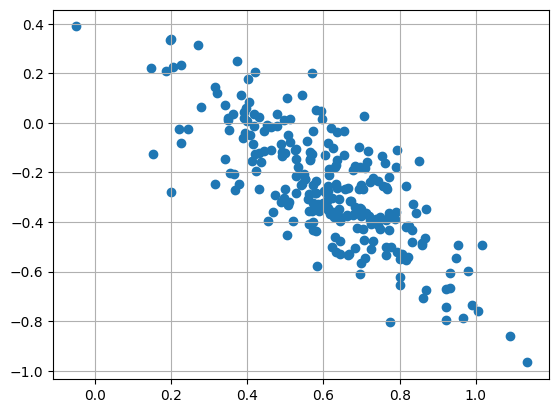

In [80]:
plt.scatter(nigeria_mms_shifts.shift1, nigeria_mms_shifts.shift2)
plt.grid()

In [81]:
location_id=165
pakistan_mms_shifts = pd.DataFrame()
for draw in list(range(0,n_draws)):
    shift1, shift2 = mms_double_shift(draw, location_id)
    temp = pd.DataFrame()
    temp['draw'] = [f'draw_{draw}']
    temp['shift1'] = [shift1]
    temp['shift2'] = [shift2]
    pakistan_mms_shifts = pd.concat([pakistan_mms_shifts, temp], ignore_index=True)
pakistan_mms_shifts['location_id'] = location_id
pakistan_mms_shifts

,draw,shift1,shift2,location_id
0,draw_0,0.711276,-0.208753,165
1,draw_1,0.497675,-0.032594,165
2,draw_2,0.590892,-0.328295,165
3,draw_3,0.690796,-0.525301,165
4,draw_4,0.712022,-0.383473,165
...,...,...,...,...
245,draw_245,0.243085,0.218325,165
246,draw_246,0.201008,0.319427,165
247,draw_247,0.833164,-0.681182,165
248,draw_248,0.609780,-0.364152,165


In [82]:
ethiopia_mms_shifts['location_id'] = 179
mms_shifts = pd.concat([ethiopia_mms_shifts,
                       nigeria_mms_shifts,
                       pakistan_mms_shifts], ignore_index=True)
mms_shifts

,draw,shift1,shift2,location_id
0,draw_0,0.661335,-0.151295,179
1,draw_1,0.467092,-0.013965,179
2,draw_2,0.606925,-0.337975,179
3,draw_3,0.617615,-0.456241,179
4,draw_4,0.682057,-0.364714,179
...,...,...,...,...
745,draw_245,0.243085,0.218325,165
746,draw_246,0.201008,0.319427,165
747,draw_247,0.833164,-0.681182,165
748,draw_248,0.609780,-0.364152,165


In [83]:
mms_shifts.to_csv('updated_mms_shifts.csv')

In [84]:
covered_exp

,location_id,age_group_id,sex_id,parameter,ga_start,ga_end,bw_start,bw_end,draw,exposure,covered_shift,frac_ptb,exposure_ptb,frac_vptb,exposure_vptb
0,214,164,1,cat2,0.054992,24.054992,0,500,draw_0,0.000764,0.054992,1.0,0.000764,1.0,0.000764
1,214,164,2,cat2,0.054992,24.054992,0,500,draw_0,0.000585,0.054992,1.0,0.000585,1.0,0.000585
2,214,164,1,cat8,0.054992,24.054992,500,1000,draw_0,0.000782,0.054992,1.0,0.000782,1.0,0.000782
3,214,164,2,cat8,0.054992,24.054992,500,1000,draw_0,0.000851,0.054992,1.0,0.000851,1.0,0.000851
4,214,164,1,cat10,24.054992,26.054992,500,1000,draw_0,0.000558,0.054992,1.0,0.000558,1.0,0.000558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86995,165,164,1,cat116,38.039735,40.039735,1000,1500,draw_249,0.009025,0.039735,0.0,0.000000,0.0,0.000000
86996,165,164,2,cat117,38.039735,40.039735,1500,2000,draw_249,0.017519,0.039735,0.0,0.000000,0.0,0.000000
86997,165,164,1,cat117,38.039735,40.039735,1500,2000,draw_249,0.016403,0.039735,0.0,0.000000,0.0,0.000000
86998,165,164,2,cat123,40.039735,42.039735,1500,2000,draw_249,0.004597,0.039735,0.0,0.000000,0.0,0.000000


In [85]:
# ok, now for some validation
mms_exp_val = covered_exp.merge(mms_shifts, on=['draw','location_id'])
mms_exp_val['ga_start'] = mms_exp_val.ga_start + mms_exp_val.shift1
mms_exp_val['ga_end'] = mms_exp_val.ga_end + mms_exp_val.shift1
mms_exp_val['frac_shift2'] = np.where(mms_exp_val.ga_start < (32 - mms_exp_val.shift2), 0, 1)
mms_exp_val['ga_start'] = mms_exp_val.ga_start + (mms_exp_val.shift2 * mms_exp_val.frac_shift2)
mms_exp_val['ga_end'] = mms_exp_val.ga_end + (mms_exp_val.shift2 * mms_exp_val.frac_shift2)

mms_exp_val['exposure_vptb'] = np.where(mms_exp_val.ga_start >= 32, 0,
                                            np.where(mms_exp_val.ga_end < 32, mms_exp_val.exposure,
                                                    ((32 - mms_exp_val.ga_start)/(mms_exp_val.ga_end - mms_exp_val.ga_start)
                                                     * mms_exp_val.exposure)))
mms_exp_val['exposure_ptb'] = np.where(mms_exp_val.ga_start >= 37, 0,
                                        np.where(mms_exp_val.ga_end < 37, mms_exp_val.exposure,
                                                ((37 - mms_exp_val.ga_start)/(mms_exp_val.ga_end - mms_exp_val.ga_start)
                                                 *mms_exp_val.exposure)))
mms_exp_val = mms_exp_val.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]
mms_exp_val

/tmp/ipykernel_2106044/996656630.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mms_exp_val = mms_exp_val.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]


exposure_ptb  exposure_vptb
location_id draw                                 
165         draw_0        0.283901       0.050903
            draw_1        0.281859       0.052229
            draw_10       0.306069       0.054389
            draw_100      0.282966       0.050222
            draw_101      0.305432       0.048175
...                            ...            ...
214         draw_95       0.296743       0.046972
            draw_96       0.288469       0.048798
            draw_97       0.300346       0.048657
            draw_98       0.301221       0.051032
            draw_99       0.272026       0.051868

[750 rows x 2 columns]

In [86]:
rrs = mms_exp_val / covered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]
rrs

/tmp/ipykernel_2106044/3982770509.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rrs = mms_exp_val / covered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]


exposure_ptb  exposure_vptb
location_id draw                                 
165         draw_0        0.868700       0.796881
            draw_1        0.882736       0.858449
            draw_10       0.941235       0.828063
            draw_100      0.904064       0.853372
            draw_101      0.930720       0.759672
...                            ...            ...
214         draw_95       0.916759       0.782767
            draw_96       0.898073       0.818430
            draw_97       0.926025       0.812167
            draw_98       0.925693       0.842114
            draw_99       0.842710       0.874795

[750 rows x 2 columns]

In [87]:
print('Validation target is: ',mms_pt_rr_draws.rr.mean().round(3),
      ' (95% CI: ',mms_pt_rr_draws.rr.quantile(0.025).round(3), 
      ", ",mms_pt_rr_draws.rr.quantile(0.975).round(3), ")")
rrs.describe(percentiles=[0.025,0.975]).exposure_ptb.filter(['mean','2.5%','97.5%'])

Validation target is:  0.912  (95% CI:  0.84 ,  0.987 )


mean     0.911362
2.5%     0.841377
97.5%    0.981787
Name: exposure_ptb, dtype: float64

In [88]:
print('Validation target is: ',mms_vpt_rr_draws.rr.mean().round(3),
      ' (95% CI: ',mms_vpt_rr_draws.rr.quantile(0.025).round(3), 
      ", ",mms_vpt_rr_draws.rr.quantile(0.975).round(3), ")")
rrs.describe(percentiles=[0.025,0.975]).exposure_vptb.filter(['mean','2.5%','97.5%'])

Validation target is:  0.813  (95% CI:  0.706 ,  0.936 )


mean     0.819582
2.5%     0.713342
97.5%    0.939751
Name: exposure_vptb, dtype: float64